In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate

from photoz_utils import *
from DataMaker import *

In [2]:
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 256
EPOCHS = 5
GB_LIMIT = 5

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [43]:
model_name = 'HSC_v6_CNNTrials_5_pooling_2x2_filters_doubled_v2'

In [4]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': True,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': True}

TRAIN_PATH = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training.hdf5'
VAL_PATH = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation.hdf5'
TEST_PATH = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5'

In [5]:
train_gen = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

In [6]:
# model
model = Sequential()
model.add(Input(shape=(5,127,127)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first'))
model.add(MaxPooling2D(pool_size = (2,2), data_format='channels_first'))
model.add(Conv2D(64, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first'))
model.add(MaxPooling2D(pool_size = (2,2), data_format='channels_first'))
model.add(Conv2D(128, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first'))
model.add(MaxPooling2D(pool_size = (2,2), data_format='channels_first'))
model.add(Conv2D(256, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first'))
model.add(MaxPooling2D(pool_size = (2,2), data_format='channels_first'))
model.add(Conv2D(256, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first'))
model.add(MaxPooling2D(pool_size = (2,2), data_format='channels_first'))
model.add(Conv2D(512, kernel_size=(3,3),activation='relu', padding='same', data_format='channels_first'))
model.add(Conv2D(512, kernel_size=(2,2),activation='relu', padding='same', data_format='channels_first'))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 127, 127)      1472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 63, 63)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 63, 63)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 31, 31)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 31, 31)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 15, 15)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 15, 15)       1

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse",metrics=[tf.keras.metrics.MeanSquaredError()])

In [8]:
model.fit(train_gen, epochs=EPOCHS, shuffle=True, verbose=1, validation_data=val_gen)

Epoch 1/5
784/784 [==============================] - 888s 620ms/step - loss: 0.1257 - mean_squared_error: 0.1257 - val_loss: 0.0837 - val_mean_squared_error: 0.0837
Epoch 2/5
784/784 [==============================] - 1933s 2s/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0738 - val_mean_squared_error: 0.0738
Epoch 3/5
784/784 [==============================] - 1993s 3s/step - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 0.0715 - val_mean_squared_error: 0.0715
Epoch 4/5
784/784 [==============================] - 1969s 3s/step - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 5/5
784/784 [==============================] - 2071s 3s/step - loss: 0.0577 - mean_squared_error: 0.0577 - val_loss: 0.0597 - val_mean_squared_error: 0.0597


In [9]:
test_preds = model.predict(test_gen)

In [19]:
test_preds.shape

(42960, 1)

In [32]:
y_pred = np.reshape(test_preds, (1, 42960))

In [40]:
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5', 'r')
y_test = hf_test['specz_redshift'][np.sort(test_gen._indices)]
objID_test = hf_test['object_id'][np.sort(test_gen._indices)]

In [ ]:
hf_test.close()

In [24]:
y_test

array([0.43601999, 0.23209   , 0.56511003, ..., 0.67514002, 1.48161995,
       0.88402998])

In [36]:
y_pred = np.ravel(y_pred) # to make ndim = 1

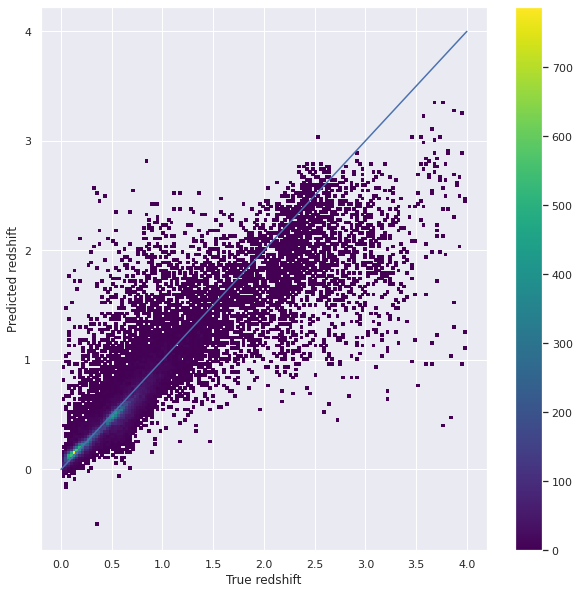

In [37]:
plot_predictions(y_pred, y_test)

In [41]:
df = pd.DataFrame(y_pred, columns=['photoz'])
df['specz'] = y_test
df['object_id'] = objID_test

In [42]:
df

,photoz,specz,object_id
0,0.337060,0.43602,36407046198803509
1,0.276666,0.23209,36407046198804043
2,0.531272,0.56511,36407050493759629
3,0.536946,0.55775,36407050493773284
4,0.405591,0.44495,36407054788744371
...,...,...,...
42955,0.693535,0.76575,74649160124473935
42956,0.872707,0.98303,74649160124493654
42957,0.536456,0.67514,74649160124502454
42958,1.507261,1.48162,74649164419466433


In [44]:
if os.path.exists(f'/predictions/{model_name}') == False:
    os.makedirs(f'/predictions/{model_name}')
    
df.to_csv(f'/predictions/{model_name}/testing_predictions_big.csv', index=False)

In [45]:
metrics = get_point_metrics(pd.Series(y_pred), pd.Series(y_test), zmax=2.5, binned=False)

if os.path.exists(f'predictions/{model_name}') ==  False:
    os.makedirs(f'predictions/{model_name}')
    
metrics.to_csv(f'/predictions/{model_name}/testing_metrics_big.csv', index=False)